## 从全连接层到卷积
问题：MLP应对高维的数据计算开销巨大
* 1. 二维互相关运算</br>
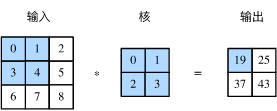
</br>
\begin{split}0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.\\\end{split}

* 2. 二维卷积层
* 3. 图像中物体边缘检测
* 4. 通过数据学习核数组
* 5. feature map 和 receptive field


In [3]:
# 二维互相关运算
import torch
from torch import nn
import dltools

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
# 二维卷积层
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [11]:
# 边缘检测
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [12]:
K = torch.tensor([[1.0, -1.0]])

In [13]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [14]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [9]:
# 卷积核
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 6.492
epoch 4, loss 1.090
epoch 6, loss 0.183
epoch 8, loss 0.031
epoch 10, loss 0.005


In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9880, -0.9855]])